In [2]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c0fa5ab2bac20d63e5568448dd8fae7abc4a98a40b3609dc0ba48d5a5dc52ac6
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [38]:
# Create a SparkSession
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

# Read the CSV file into a Spark DataFrame
data = spark.read.csv("/content/drive/MyDrive/Financial_Fraud.csv", header=True, inferSchema = True)

In [39]:
# Show the schema and first few rows of the data
data.printSchema()
data.show(5)

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)

+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
| 278| CASH_IN| 330218.42| C632336343|      20866.0|     351084.42| C834976624|     452419.57|     122201.15|      0|             0|
|

In [40]:
data.count()

100000

In [41]:
# Perform basic EDA
data.groupBy("type").count().show()
data.groupBy("isFraud").count().show()

+--------+-----+
|    type|count|
+--------+-----+
|TRANSFER| 8349|
| CASH_IN|22141|
|CASH_OUT|35334|
| PAYMENT|33564|
|   DEBIT|  612|
+--------+-----+

+-------+-----+
|isFraud|count|
+-------+-----+
|      1|  141|
|      0|99859|
+-------+-----+



In [42]:
# Add columns to identify the type of transaction
data = data.withColumn("isPayment", when(col("type") == "PAYMENT", 1).otherwise(0))
data = data.withColumn("isTransfer", when(col("type") == "TRANSFER", 1).otherwise(0))
data = data.withColumn("isCashOut", when(col("type") == "CASH_OUT", 1).otherwise(0))
data = data.withColumn("isDebit", when(col("type") == "DEBIT", 1).otherwise(0))

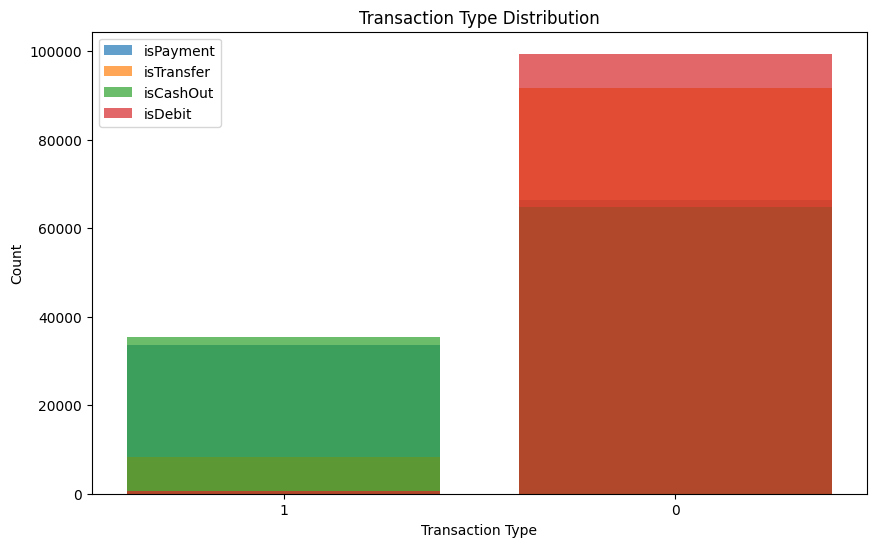

In [43]:
# Transaction Type Distribution
transaction_types = ["isPayment", "isTransfer", "isCashOut", "isDebit"]

plt.figure(figsize=(10, 6))
for t in transaction_types:
    counts = data.groupBy(t).count().collect()
    counts = [row['count'] for row in counts]
    labels = [str(row[t]) for row in data.groupBy(t).count().collect()]
    plt.bar(labels, counts, alpha=0.7, label=t)

plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.title('Transaction Type Distribution')
plt.legend()
plt.show()

In [44]:
from pyspark.ml.feature import Imputer
# Select relevant features for the model
feature_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isPayment", "isTransfer", "isCashOut", "isDebit"]

# Impute median values for nulls
imputer = Imputer(
    inputCols=feature_cols,
    outputCols=feature_cols  # Use the same feature_cols as outputCols to retain original column names
).setStrategy("median")

data = imputer.fit(data).transform(data)

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data = assembler.transform(data)

In [45]:
# Select the imputed features as 'features' column
data = data.select("features", "isFraud")  # Assuming "isFraud" is your label column
data.show(5)

+--------------------+-------+
|            features|isFraud|
+--------------------+-------+
|[330218.42,20866....|      0|
|(9,[0,1,2,5],[116...|      0|
|[152264.21,106589...|      0|
|(9,[0,3,4,6],[155...|      0|
|[78172.3,2921331....|      0|
+--------------------+-------+
only showing top 5 rows



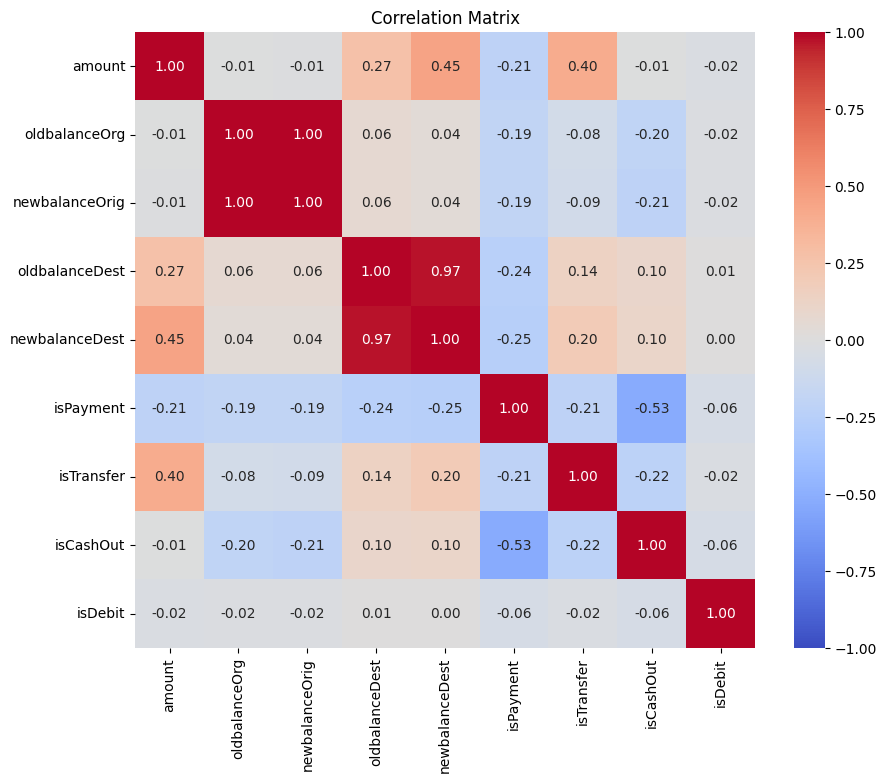

In [46]:
from pyspark.ml.stat import Correlation

# Compute correlation matrix
corr_matrix = Correlation.corr(data, "features").head()
corr_matrix = corr_matrix[0].toArray()

# Convert to Pandas DataFrame for visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cols = feature_cols
corr_df = pd.DataFrame(corr_matrix, index=cols, columns=cols)

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

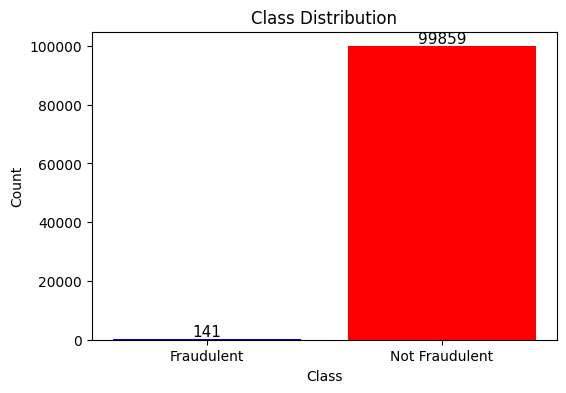

In [47]:
# Class Distribution
class_distribution = data.groupBy("isFraud").count().collect()
counts = [row['count'] for row in class_distribution]
labels = ["Not Fraudulent" if row['isFraud'] == 0 else "Fraudulent" for row in class_distribution]

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, counts, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

# Add counts at the top of each bar
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
             ha='center', va='bottom', fontsize=11)

plt.show()

### ML Models

**Data Preparation**

In [15]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.sql.functions import col, when

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

# Define class weights based on class imbalance ratio
class_weights = data.select("isFraud").groupBy("isFraud").count()
total = data.count()
class_weights = class_weights.withColumn("weight", when(col("isFraud") == 0, total / (2 * class_weights.count())).otherwise(total / (2 * class_weights.count())))

# Add class weights to training data
data = data.join(class_weights, "isFraud")

# Select the scaled features and label with class weights for the model
data = data.select(col("scaledFeatures").alias("features"), col("isFraud").alias("label"), col("weight"))

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

**Logistic Regression**

In [16]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Build and train the logistic regression model with class weights
lr = LogisticRegression(featuresCol="features", labelCol="label", weightCol="weight")

# Set up the parameter grid
param_grid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Set up the cross-validator
crossval_lr = CrossValidator(estimator=lr,
                             estimatorParamMaps=param_grid_lr,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3)  # Adjust numFolds as needed

# Train the logistic regression model
cv_model_lr = crossval_lr.fit(train_data)

# Make predictions on the test set
predictions_lr = cv_model_lr.transform(test_data)

# Evaluate the model
evaluator_lr = BinaryClassificationEvaluator()
auc_lr = evaluator_lr.evaluate(predictions_lr)
print(f"AUC for Logistic Regression: {auc_lr}")



AUC for Logistic Regression: 0.9223328355732541


In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Extract predictions and labels from DataFrame
predictions_and_labels_lr = predictions_lr.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Convert predictions and labels to lists
predictions_list_lr = predictions_and_labels_lr.map(lambda x: x[0]).collect()
labels_list_lr = predictions_and_labels_lr.map(lambda x: x[1]).collect()

# Create confusion matrix
cm_lr = confusion_matrix(labels_list_lr, predictions_list_lr)
# Print confusion matrix
print("Confusion Matrix:")
print("             Predicted Negative   Predicted Positive")
print("Actual Negative      ", cm_lr[0][0], "                 ", cm_lr[0][1])
print("Actual Positive      ", cm_lr[1][0], "                 ", cm_lr[1][1])

# Calculate accuracy
accuracy = accuracy_score(labels_list_lr, predictions_list_lr)

# Calculate precision, recall, and F1-score
precision = precision_score(labels_list_lr, predictions_list_lr)
recall = recall_score(labels_list_lr, predictions_list_lr)
f1 = f1_score(labels_list_lr, predictions_list_lr)

# Print metrics
print("\nMetrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Confusion Matrix:
             Predicted Negative   Predicted Positive
Actual Negative       20090                   0
Actual Positive       30                   0

Metrics:
Accuracy : 0.9985
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Build and train the random forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", weightCol="weight")

# Set up the parameter grid
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# Set up the cross-validator
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=param_grid_rf,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3)

# Train the random forest classifier
cv_model_rf = crossval_rf.fit(train_data)

# Make predictions on the test set
predictions_rf = cv_model_rf.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator()
auc_rf = evaluator.evaluate(predictions_rf)
print(f"AUC for Random Forest: {auc_rf}")


AUC for Random Forest: 0.9913928986228638


In [49]:
# Extract predictions and labels from DataFrame
predictions_and_labels_rf = predictions_rf.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Convert predictions and labels to lists
predictions_list_rf = predictions_and_labels_rf.map(lambda x: x[0]).collect()
labels_list_rf = predictions_and_labels_rf.map(lambda x: x[1]).collect()

# Create confusion matrix
cm_rf = confusion_matrix(labels_list_rf, predictions_list_rf)
# Print confusion matrix with labels
print("Confusion Matrix:")
print("             Predicted Negative   Predicted Positive")
print("Actual Negative      ", cm_rf[0][0], "                 ", cm_rf[0][1])
print("Actual Positive      ", cm_rf[1][0], "                 ", cm_rf[1][1])

# Calculate accuracy
accuracy = accuracy_score(labels_list_rf, predictions_list_rf)

# Calculate precision, recall, and F1-score
precision = precision_score(labels_list_rf, predictions_list_rf)
recall = recall_score(labels_list_rf, predictions_list_rf)
f1 = f1_score(labels_list_rf, predictions_list_rf)

# Print metrics
print("\nMetrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Confusion Matrix:
             Predicted Negative   Predicted Positive
Actual Negative       20090                   0
Actual Positive       10                   20

Metrics:
Accuracy : 0.9995
Precision: 1.0000
Recall   : 0.6667
F1-score : 0.8000


**Gradient Boosted Tree**

In [22]:
# Build and train the gradient-boosted tree classifier
gbt = GBTClassifier(featuresCol="features", labelCol="label", weightCol="weight")

# Set up the parameter grid
param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20]) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .build()

# Set up the cross-validator
crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=param_grid_gbt,
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=3)

# Train the gradient-boosted tree classifier
cv_model_gbt = crossval_gbt.fit(train_data)

# Make predictions on the test set
predictions_gbt = cv_model_gbt.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator()
auc_gbt = evaluator.evaluate(predictions_gbt)
print(f"AUC for Gradient-Boosted Tree: {auc_gbt}")

AUC for Gradient-Boosted Tree: 0.9930554172888668


In [50]:
# Extract predictions and labels from DataFrame
predictions_and_labels_gbt = predictions_gbt.select("prediction", "label").rdd.map(lambda row: (row.prediction, row.label))

# Convert predictions and labels to lists
predictions_list_gbt = predictions_and_labels_gbt.map(lambda x: x[0]).collect()
labels_list_gbt = predictions_and_labels_gbt.map(lambda x: x[1]).collect()

# Create confusion matrix
cm_gbt = confusion_matrix(labels_list_gbt, predictions_list_gbt)

# Print confusion matrix with labels
print("Confusion Matrix:")
print("             Predicted Negative   Predicted Positive")
print("Actual Negative      ", cm_gbt[0][0], "                 ", cm_gbt[0][1])
print("Actual Positive      ", cm_gbt[1][0], "                 ", cm_gbt[1][1])

# Calculate accuracy
accuracy = accuracy_score(labels_list_gbt, predictions_list_gbt)

# Calculate precision, recall, and F1-score
precision = precision_score(labels_list_gbt, predictions_list_gbt)
recall = recall_score(labels_list_gbt, predictions_list_gbt)
f1 = f1_score(labels_list_gbt, predictions_list_gbt)

# Print metrics
print("\nMetrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

Confusion Matrix:
             Predicted Negative   Predicted Positive
Actual Negative       20090                   0
Actual Positive       8                   22

Metrics:
Accuracy : 0.9996
Precision: 1.0000
Recall   : 0.7333
F1-score : 0.8462


### DL Model

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [25]:
# Define the neural network model
model = Sequential()
model.add(Dense(32, input_dim=len(feature_cols), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
import numpy as np

# Convert features and labels from Spark DataFrame to NumPy arrays
train_features = np.array(train_data.select('features').rdd.map(lambda row: row.features.toArray()).collect())
train_labels = np.array(train_data.select('label').rdd.map(lambda row: row.label).collect())

test_features = np.array(test_data.select('features').rdd.map(lambda row: row.features.toArray()).collect())
test_labels = np.array(test_data.select('label').rdd.map(lambda row: row.label).collect())

In [28]:
# Calculate class frequencies
class_counts = train_data.groupBy("label").count()

# Calculate total number of instances
total_instances = train_data.count()

# Calculate class weights based on frequency
class_weights = class_counts.withColumn(
    "weight",
    (total_instances / (class_counts["count"] * class_counts.count())).cast("double")
).select("label", "weight").rdd.collectAsMap()

# Example adjustment (customize as per your dataset)
imbalance_factor = 5.0
class_weights_adjusted = {k: v * imbalance_factor for k, v in class_weights.items()}

In [29]:
# Train the model with class weights
model.fit(train_features, train_labels, epochs=20, batch_size=32, validation_split=0.2, class_weight=class_weights_adjusted)

Epoch 1/20
1997/1997 [==============================] - 9s 3ms/step - loss: 2.4995 - accuracy: 0.8634 - val_loss: 0.3630 - val_accuracy: 0.7723
Epoch 2/20
1997/1997 [==============================] - 5s 3ms/step - loss: 1.6576 - accuracy: 0.8640 - val_loss: 0.4394 - val_accuracy: 0.7129
Epoch 3/20
1997/1997 [==============================] - 6s 3ms/step - loss: 1.2720 - accuracy: 0.8942 - val_loss: 0.1707 - val_accuracy: 0.9788
Epoch 4/20
1997/1997 [==============================] - 5s 3ms/step - loss: 1.2019 - accuracy: 0.9048 - val_loss: 0.3785 - val_accuracy: 0.7193
Epoch 5/20
1997/1997 [==============================] - 12s 6ms/step - loss: 1.0986 - accuracy: 0.9105 - val_loss: 0.2439 - val_accuracy: 0.8937
Epoch 6/20
1997/1997 [==============================] - 6s 3ms/step - loss: 0.9941 - accuracy: 0.9360 - val_loss: 0.1440 - val_accuracy: 0.9869
Epoch 7/20
1997/1997 [==============================] - 9s 4ms/step - loss: 0.9458 - accuracy: 0.9383 - val_loss: 0.1697 - val_accuracy

In [30]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_features, test_labels)

print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")

629/629 [==============================] - 2s 3ms/step - loss: 0.1116 - accuracy: 0.9594
Loss on test data: 0.11162276566028595
Accuracy on test data: 0.9594433307647705


In [31]:
# Make predictions on test data
predictions = model.predict(test_features)

629/629 [==============================] - 5s 7ms/step


In [32]:
# Convert predictions to binary values (0 or 1) based on threshold = 0.5
binary_predictions = (predictions > 0.5).astype(int)

In [33]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, binary_predictions)

# Print confusion matrix with labels
print("Confusion Matrix:")
print("             Predicted Negative   Predicted Positive")
print("Actual Negative      ", cm[0][0], "                 ", cm[0][1])
print("Actual Positive      ", cm[1][0], "                 ", cm[1][1])

Confusion Matrix:
             Predicted Negative   Predicted Positive
Actual Negative       19274                   816
Actual Positive       0                   30


In [34]:
# Compute precision, recall, f1-score, and accuracy
precision = precision_score(test_labels, binary_predictions)
recall = recall_score(test_labels, binary_predictions)
f1 = f1_score(test_labels, binary_predictions)
accuracy = accuracy_score(test_labels, binary_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.03546099290780142
Recall: 1.0
F1-score: 0.06849315068493152
Accuracy: 0.9594433399602386


In [35]:
# Calculate ROC curve and AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(test_labels, binary_predictions)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

AUC: 0.9796913887506222


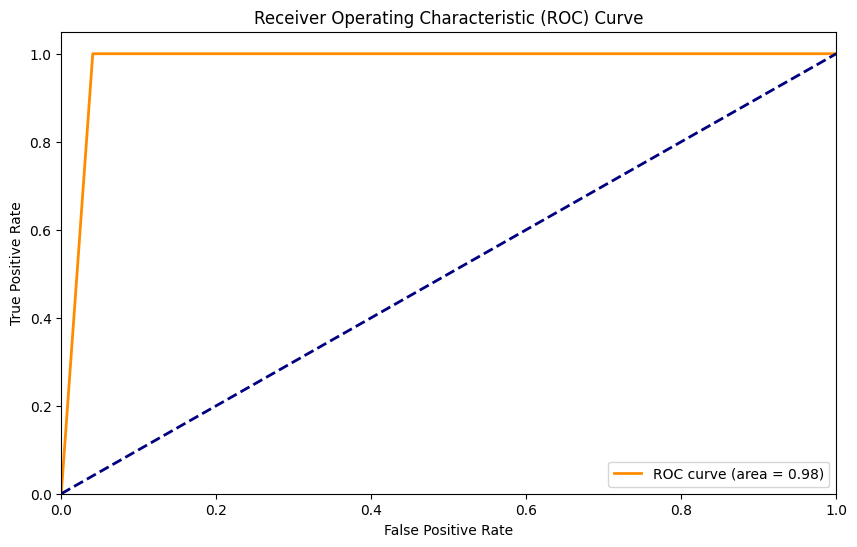

In [36]:
# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()